In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import read_roi
from read_roi import read_roi_zip
from collections import OrderedDict
import pathlib
from pyometiff import OMETIFFReader
import skimage as ski
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

In [87]:
import glob, os

dir_path = "/Users/letroter.a/Desktop/calimglia/expe/"

for root, dirs, files in os.walk(dir_path):
    i = 0
    for file in files:
        if file.endswith('.DS_Store'):
            path = os.path.join(root, file)

            print("Deleting: %s" % (path))

            if os.remove(path):
                print("Unable to delete!")
            else:
                print("Deleted...")
                i += 1

print("Files Deleted: %d" % (i))

Deleting: /Users/letroter.a/Desktop/calimglia/expe/.DS_Store
Deleted...
Deleting: /Users/letroter.a/Desktop/calimglia/expe/reg/.DS_Store
Deleted...
Files Deleted: 0


In [12]:
import pandas as pd

df = pd.DataFrame()

timepoint = 100 
downsample_factor_x_y = 4
downsample_factor_t = 50

xform = np.eye(4)
xform_mask = np.eye(4)
hdr = nib.Nifti1Header()

list_exp = os.listdir(dir_path)

for exp in list_exp:
    print("experience: ", exp)

    list_files = os.listdir(os.path.join(dir_path,str(exp)))

    for file in list_files:
      if file.endswith(".zip"):
        print("read ROI")
          
        zip_file = os.path.join( dir_path , str(exp) , "RoiSet.zip")
        
        mask_number = 0
        mask_shape = ((128, 128))
        polygon_list = []
        all_masks = np.zeros(mask_shape)
    
        if (os.path.isfile(zip_file)):
            
            my_rois = read_roi.read_roi_zip(zip_file)

            for i in my_rois.keys():
                print(my_rois[i]['name'], my_rois[i]['type'])
                if (my_rois[i]['type']=='oval'):
                    print("ROI skipped")
                    
                if (my_rois[i]['type']=='freehand'):

                    mask_number = mask_number + 1
                    new_polygon = []
                    print("ROI ", mask_number, "freehand founded ")
    
                    for n in range(0,len(my_rois[i]['x'])):
                        new_polygon.append([my_rois[i]['x'][n] / downsample_factor_x_y ,my_rois[i]['y'][n] / downsample_factor_x_y  ])

                    if (len(new_polygon)> 0):
                        polygon_list.append(new_polygon)                            
                        mask = ski.draw.polygon2mask(mask_shape, polygon_list[mask_number-1])
                        mask.astype(int)
                        mask_downscaled = rescale(mask, 1, anti_aliasing=False)         
                        mask_labeled = mask_downscaled.astype(int) * mask_number
                        mask_label = np.zeros(mask_shape)
                        mask_label = np.add(mask_label,mask_downscaled)
                        mask_label_nii = nib.Nifti1Image(mask_label, xform_mask,hdr)

                        mask_label_nii_name_ds_x_y_t = os.path.join( dir_path + str(exp) ,'mask' + str(mask_number) +'.nii.gz' )
                        
                        nib.save(mask_label_nii, mask_label_nii_name_ds_x_y_t)
                        
                        all_masks = np.add(all_masks,mask_labeled)

        all_masks_nii = nib.Nifti1Image(all_masks, xform_mask,hdr)
        allmask_filename = dir_path + '/' + str(exp) + '/labels.nii.gz' 
        nib.save(all_masks_nii, allmask_filename)

      if file.endswith(".ome.tiff"):
        img_ometif_name = dir_path + '/' + str(exp) + '/'  + str(file)
        img_fpath = pathlib.Path(img_ometif_name)
        filename_nii_ds_x_y_t = file.replace(".ome.tiff", "_ds.nii.gz")
        ome_to_nii_name_ds_x_y_t = os.path.join(dir_path,str(exp),str(downsample_factor_x_y)+'_'+str(downsample_factor_t)+'_'+filename_nii_ds_x_y_t)
        print(ome_to_nii_name_ds_x_y_t)
        print("convert",img_fpath,"to", filename_nii_ds_x_y_t)

        check_file = os.path.exists(ome_to_nii_name_ds_x_y_t)

        if (not check_file):
            reader = OMETIFFReader(fpath=img_fpath)
            img_array, metadata, xml_metadata = reader.read()
            img_array_flip = np.swapaxes(img_array,2,0)
            img_array_downscaled = downscale_local_mean(img_array_flip, (downsample_factor_x_y, downsample_factor_x_y, downsample_factor_t) )
            img_array_downscaled_res = np.reshape(img_array_downscaled, (img_array_downscaled.shape[0], img_array_downscaled.shape[1], 1, img_array_downscaled.shape[2]))
            convert_ome_to_nii_downscaled = nib.Nifti1Image(img_array_downscaled_res, xform)
            print(img_array_downscaled_res.shape)
            nib.save(convert_ome_to_nii_downscaled, ome_to_nii_name_ds_x_y_t)




experience:  reg
experience:  slice1_L2_20X
/Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/4_50_0_2_ds.nii.gz
convert /Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/0_2.ome.tiff to 0_2_ds.nii.gz
/Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/4_50_0_3_ds.nii.gz
convert /Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/0_3.ome.tiff to 0_3_ds.nii.gz
/Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/4_50_0_5_ds.nii.gz
convert /Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/0_5.ome.tiff to 0_5_ds.nii.gz
/Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/4_50_0_4_ds.nii.gz
convert /Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/0_4.ome.tiff to 0_4_ds.nii.gz
read ROI
0001-0330-0280 freehand
ROI  1 freehand founded 
0636-0336-0286 freehand
ROI  2 freehand founded 
0636-0100-0328 oval
ROI skipped
0001-0181-0341 freehand
ROI  3 freehand founded 
0001-0345-0211 oval
ROI skipped
0734-0094-0132 oval
ROI skipped
2663-0296-0416 oval
ROI skipped
/Use

In [13]:
#import ants
import os
import numpy   as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [14]:
def read_image_nii(folder, index ):
  mask = nib.load(os.path.join( folder , 'mask' + str(index) + '.nii.gz'))
  mask_data=mask.get_fdata()
  return (mask_data)

In [15]:
for exp in list_exp:
    print("experience: ", exp)

experience:  reg
experience:  slice1_L2_20X
experience:  slice2_L2_20X


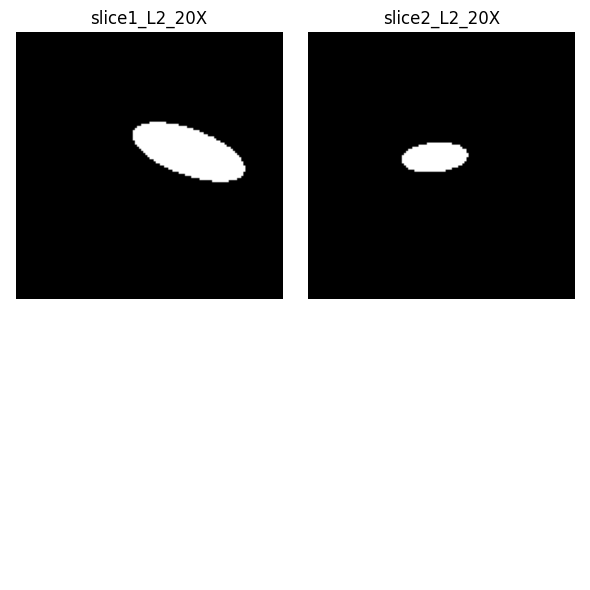

True

In [37]:
index_source = 1
index_target = 2

mask_data_src=read_image_nii( os.path.join( dir_path ,"slice1_L2_20X"), index_source)
mask_data_target=read_image_nii( os.path.join( dir_path ,"slice2_L2_20X"), index_target)

plt.figure(figsize=(6,6))
plt.axis('Off')
plt.subplot(2,2,1)
plt.imshow(mask_data_src, cmap="gray", origin="lower")
plt.title('slice1_L2_20X')
plt.axis('off')
plt.subplot(2,2,2)
plt.title("slice2_L2_20X")
plt.imshow(mask_data_target, cmap="gray", origin="lower")
plt.axis('Off')
plt.tight_layout()
plt.show()

# Filename
filename = 'expe/reg/mask_slice1_L2_20X.bmp'
uint_img = np.array(mask_data_src*255).astype('uint8')
cv2.imwrite(filename, uint_img)
filename = 'expe/reg/mask_slice2_L2_20X.bmp'
uint_img = np.array(mask_data_target*255).astype('uint8')
cv2.imwrite(filename, uint_img)

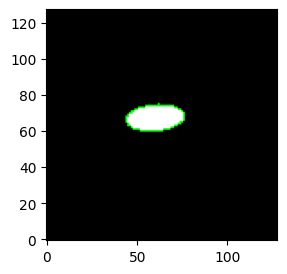

In [38]:
image=cv2.imread(filename)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,100,200)
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
ellipse = cv2.fitEllipse(max(contours,key=cv2.contourArea))
cv2.ellipse(image,ellipse,(0,255,0),1)

plt.figure(figsize=(3,3))
plt.imshow(image, cmap="gray", origin="lower")
plt.show()

True

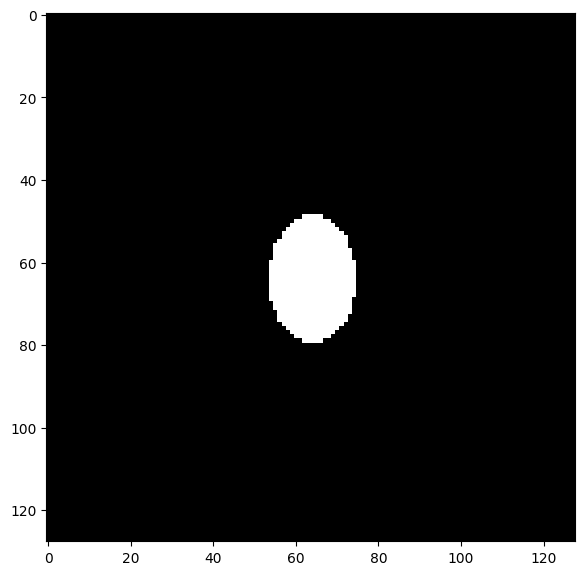

In [77]:
template = np.zeros([128, 128, 3], dtype=np.uint8)
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

# draw ellipse on template_moving (normal eyes)
thickness = -1 #filled
#thickness = 0 #wire
cv2.ellipse(template_gray,(64,64),(10,15),1,0,360,(255,255,255),thickness, cv2.FILLED,0)

# draw ellipse on template_target (fisheyes)
#cv.circle(template_fisheyes_target,(,(64,64,20,(255,255,255),2,8,0)
plt.figure(figsize=(15,12))
plt.subplot(1,2,1)
plt.imshow(template_gray,cmap=cm.gray)
cv2.imwrite("expe/reg/template.bmp",template_gray)

In [85]:
import subprocess

#mask_slice1 = 'expe/reg/mask_slice1_L2_20X.bmp'
#mask_slice2 = 'expe/reg/mask_slice2_L2_20X.bmp'
mask_template = 'expe/reg/template.bmp'

#mask_slice1_nii = mask_slice1.replace(".bmp", ".nii.gz")
#mask_slice2_nii = mask_slice2.replace(".bmp", ".nii.gz")

mask_slice1_nii = 'expe/slice1_L2_20X/mask1.nii.gz'
mask_slice2_nii = 'expe/slice2_L2_20X/mask2.nii.gz'

mask_template_nii = mask_template.replace(".bmp", ".nii.gz")

#subprocess.run(["ConvertImage", "2", mask_slice1, mask_slice1_nii]) 
#subprocess.run(["ConvertImage", "2", mask_slice2, mask_slice2_nii]) 
subprocess.run(["ConvertImage", "2", mask_template, mask_template_nii]) 

#subprocess.run(["CopyImageHeaderInformation", mask_template_nii,  filename_nii_ds_x_y_t_tmean, filename_nii_ds_x_y_t_tmean,  "1 1 1"])  
#subprocess.run(["CopyImageHeaderInformation", mask_template_nii,  filename_nii_ds_x_y_t_tmax, filename_nii_ds_x_y_t_tmax,  "1 1 1"]) 
#subprocess.run(["fslcpgeom", mask_template_nii,  mask_slice1_nii])  
#subprocess.run(["fslcpgeom", mask_template_nii,  mask_slice2_nii]) 


### Affine registration
matrice_slice1 = 'expe/reg/mask_slice1_L2_20X.omat'
matrice_slice2 = 'expe/reg/mask_slice2_L2_20X.omat'
mask_warped_slice1 = 'expe/reg/mask_slice1_L2_20X_warped.nii.gz'
mask_warped_slice2 = 'expe/reg/mask_slice2_L2_20X_warped.nii.gz'
subprocess.run(["flirt", "-in" , mask_slice1_nii, "-ref", mask_template_nii, "-omat", matrice_slice1, "-o" ,mask_warped_slice1, "-2D","-v"])  
subprocess.run(["flirt", "-in" , mask_slice2_nii, "-ref", mask_template_nii, "-omat", matrice_slice2, "-o" ,mask_warped_slice2, "-2D","-v"])

subprocess.run(["fslcpgeom", mask_slice1_nii,  mask_warped_slice1])  
subprocess.run(["fslcpgeom", mask_slice2_nii,  mask_warped_slice2]) 



Init Matrix = 
1.000000 0.000000 0.000000 0.000000 
0.000000 1.000000 0.000000 0.000000 
0.000000 0.000000 1.000000 0.000000 
0.000000 0.000000 0.000000 1.000000 

 >> # 8mm scale
 >> setscale 8
 >> setoption smoothing 8
 >> setoption paramsubset 3  0 0 1 0 0 0 0 0 0 0 0 0  0 0 0 1 0 0 0 0 0 0 0 0  0 0 0 0 1 0 0 0 0 0 0 0
 >> clear U
 >> clear UA
 >> setrow UA 1 0 0 0  0 1 0 0  0 0 1 0  0 0 0 1
 >> optimise 12 UA:1  0.0   0.0   0.0   0.0   0.0   0.0   0.0  rel 4 
 >> 
 >> # 4mm scale
 >> setscale 4
 >> setoption smoothing 4
 >> setoption paramsubset 3  0 0 1 0 0 0 0 0 0 0 0 0  0 0 0 1 0 0 0 0 0 0 0 0  0 0 0 0 1 0 0 0 0 0 0 0
 >> clear UB
 >> clear UL
 >> clear UM
 >> # remeasure costs at this scale
 >> clear U
 >> measurecost 12 UA 0 0 0 0 0 0 rel
 >> sort U
 >> copy U UL
 >> # optimise best 3 candidates
 >> clear U
 >> optimise 12 UL:1-3  0.0   0.0   0.0   0.0   0.0   0.0   0.0  rel 4
 >> # also try the identity transform as a starting point at this resolution
 >> clear UQ
 >> setrow 

CompletedProcess(args=['fslcpgeom', 'expe/slice2_L2_20X/mask2.nii.gz', 'expe/reg/mask_slice2_L2_20X_warped.nii.gz'], returncode=0)

In [88]:
list_exp = os.listdir(dir_path)

for exp in list_exp:
    print("experience: ", exp)
    list_files = os.listdir(os.path.join(dir_path,str(exp)))
    for file in list_files:
      if file.endswith(".ome.tiff"):
        img_ometif_name = dir_path + '/' + str(exp) + '/'  + str(file)
        filename_nii_ds_x_y_t = file.replace(".ome.tiff", "_ds.nii.gz")
        ome_to_nii_name_ds_x_y_t = os.path.join(dir_path,str(exp),str(downsample_factor_x_y)+'_'+str(downsample_factor_t)+'_'+filename_nii_ds_x_y_t)
        filename_nii_ds_x_y_t_tmean = ome_to_nii_name_ds_x_y_t.replace("_ds.nii.gz", "_ds_Tmean.nii.gz")
        filename_nii_ds_x_y_t_tmax = ome_to_nii_name_ds_x_y_t.replace("_ds.nii.gz", "_ds_Tmax.nii.gz")
        #-Tmax & -Tmean
        print(filename_nii_ds_x_y_t_tmax)
        subprocess.run(["fslmaths", ome_to_nii_name_ds_x_y_t, "-Tmean", filename_nii_ds_x_y_t_tmean]) 
        subprocess.run(["fslmaths", ome_to_nii_name_ds_x_y_t, "-Tmax", filename_nii_ds_x_y_t_tmax]) 

        subprocess.run(["CopyImageHeaderInformation", mask_template_nii,  filename_nii_ds_x_y_t_tmean, filename_nii_ds_x_y_t_tmean,  "1 1 1"])  
        subprocess.run(["CopyImageHeaderInformation", mask_template_nii,  filename_nii_ds_x_y_t_tmax, filename_nii_ds_x_y_t_tmax,  "1 1 1"]) 

        subprocess.run(["fslcpgeom", mask_template_nii,  filename_nii_ds_x_y_t_tmean])  
        subprocess.run(["fslcpgeom", mask_template_nii,  filename_nii_ds_x_y_t_tmax]) 

        filename_nii_ds_x_y_t_tmean_reg = ome_to_nii_name_ds_x_y_t.replace("_ds.nii.gz", "_ds_Tmean_registered.nii.gz")
        filename_nii_ds_x_y_t_tmax_reg = ome_to_nii_name_ds_x_y_t.replace("_ds.nii.gz", "_ds_Tmax_registered.nii.gz")

        matrice = "expe/reg/mask_"+ str(exp) + ".omat"

        subprocess.run(["flirt", "-in" , filename_nii_ds_x_y_t_tmax, "-ref", mask_template_nii, "-init", matrice,  "-applyxfm", "-2D", "-o", filename_nii_ds_x_y_t_tmax_reg,"-v"])  
        subprocess.run(["flirt", "-in" , filename_nii_ds_x_y_t_tmean, "-ref", mask_template_nii, "-init", matrice,  "-applyxfm", "-2D", "-o", filename_nii_ds_x_y_t_tmean_reg,"-v"])  

        subprocess.run(["fslcpgeom", mask_template_nii,  filename_nii_ds_x_y_t_tmax_reg])  
        subprocess.run(["fslcpgeom", mask_template_nii,  filename_nii_ds_x_y_t_tmean_reg]) 




experience:  reg
experience:  slice1_L2_20X
/Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/4_50_0_2_ds_Tmax.nii.gz


The output image will use the sform from the reference image
Init Matrix = 
0.940795 -0.338974 0.000000 37.271073 
0.338974 0.940795 0.000000 -32.003435 
0.000000 0.000000 1.000000 0.000000 
0.000000 0.000000 0.000000 1.000000 

The output image will use the sform from the reference image
Init Matrix = 
0.940795 -0.338974 0.000000 37.271073 
0.338974 0.940795 0.000000 -32.003435 
0.000000 0.000000 1.000000 0.000000 
0.000000 0.000000 0.000000 1.000000 

/Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/4_50_0_3_ds_Tmax.nii.gz


The output image will use the sform from the reference image
Init Matrix = 
0.940795 -0.338974 0.000000 37.271073 
0.338974 0.940795 0.000000 -32.003435 
0.000000 0.000000 1.000000 0.000000 
0.000000 0.000000 0.000000 1.000000 

The output image will use the sform from the reference image
Init Matrix = 
0.940795 -0.338974 0.000000 37.271073 
0.338974 0.940795 0.000000 -32.003435 
0.000000 0.000000 1.000000 0.000000 
0.000000 0.000000 0.000000 1.000000 

/Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/4_50_0_5_ds_Tmax.nii.gz


The output image will use the sform from the reference image
Init Matrix = 
0.940795 -0.338974 0.000000 37.271073 
0.338974 0.940795 0.000000 -32.003435 
0.000000 0.000000 1.000000 0.000000 
0.000000 0.000000 0.000000 1.000000 

The output image will use the sform from the reference image
Init Matrix = 
0.940795 -0.338974 0.000000 37.271073 
0.338974 0.940795 0.000000 -32.003435 
0.000000 0.000000 1.000000 0.000000 
0.000000 0.000000 0.000000 1.000000 

/Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/4_50_0_4_ds_Tmax.nii.gz


The output image will use the sform from the reference image
Init Matrix = 
0.940795 -0.338974 0.000000 37.271073 
0.338974 0.940795 0.000000 -32.003435 
0.000000 0.000000 1.000000 0.000000 
0.000000 0.000000 0.000000 1.000000 

The output image will use the sform from the reference image
Init Matrix = 
0.940795 -0.338974 0.000000 37.271073 
0.338974 0.940795 0.000000 -32.003435 
0.000000 0.000000 1.000000 0.000000 
0.000000 0.000000 0.000000 1.000000 

/Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/4_50_0_1_ds_Tmax.nii.gz


The output image will use the sform from the reference image
Init Matrix = 
0.940795 -0.338974 0.000000 37.271073 
0.338974 0.940795 0.000000 -32.003435 
0.000000 0.000000 1.000000 0.000000 
0.000000 0.000000 0.000000 1.000000 

The output image will use the sform from the reference image
Init Matrix = 
0.940795 -0.338974 0.000000 37.271073 
0.338974 0.940795 0.000000 -32.003435 
0.000000 0.000000 1.000000 0.000000 
0.000000 0.000000 0.000000 1.000000 

/Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/4_50_0_6_ds_Tmax.nii.gz


The output image will use the sform from the reference image
Init Matrix = 
0.940795 -0.338974 0.000000 37.271073 
0.338974 0.940795 0.000000 -32.003435 
0.000000 0.000000 1.000000 0.000000 
0.000000 0.000000 0.000000 1.000000 

The output image will use the sform from the reference image
Init Matrix = 
0.940795 -0.338974 0.000000 37.271073 
0.338974 0.940795 0.000000 -32.003435 
0.000000 0.000000 1.000000 0.000000 
0.000000 0.000000 0.000000 1.000000 

experience:  slice2_L2_20X
/Users/letroter.a/Desktop/calimglia/expe/slice2_L2_20X/4_50_0_2_ds_Tmax.nii.gz


The output image will use the sform from the reference image
Init Matrix = 
0.996349 0.085373 0.000000 -1.470264 
-0.085373 0.996349 0.000000 9.143511 
0.000000 0.000000 1.000000 -0.000000 
0.000000 0.000000 0.000000 1.000000 

The output image will use the sform from the reference image
Init Matrix = 
0.996349 0.085373 0.000000 -1.470264 
-0.085373 0.996349 0.000000 9.143511 
0.000000 0.000000 1.000000 -0.000000 
0.000000 0.000000 0.000000 1.000000 

/Users/letroter.a/Desktop/calimglia/expe/slice2_L2_20X/4_50_0_3_ds_Tmax.nii.gz


The output image will use the sform from the reference image
Init Matrix = 
0.996349 0.085373 0.000000 -1.470264 
-0.085373 0.996349 0.000000 9.143511 
0.000000 0.000000 1.000000 -0.000000 
0.000000 0.000000 0.000000 1.000000 

The output image will use the sform from the reference image
Init Matrix = 
0.996349 0.085373 0.000000 -1.470264 
-0.085373 0.996349 0.000000 9.143511 
0.000000 0.000000 1.000000 -0.000000 
0.000000 0.000000 0.000000 1.000000 

/Users/letroter.a/Desktop/calimglia/expe/slice2_L2_20X/4_50_0_8_ds_Tmax.nii.gz


The output image will use the sform from the reference image
Init Matrix = 
0.996349 0.085373 0.000000 -1.470264 
-0.085373 0.996349 0.000000 9.143511 
0.000000 0.000000 1.000000 -0.000000 
0.000000 0.000000 0.000000 1.000000 

The output image will use the sform from the reference image
Init Matrix = 
0.996349 0.085373 0.000000 -1.470264 
-0.085373 0.996349 0.000000 9.143511 
0.000000 0.000000 1.000000 -0.000000 
0.000000 0.000000 0.000000 1.000000 

/Users/letroter.a/Desktop/calimglia/expe/slice2_L2_20X/4_50_0_5_ds_Tmax.nii.gz


The output image will use the sform from the reference image
Init Matrix = 
0.996349 0.085373 0.000000 -1.470264 
-0.085373 0.996349 0.000000 9.143511 
0.000000 0.000000 1.000000 -0.000000 
0.000000 0.000000 0.000000 1.000000 

The output image will use the sform from the reference image
Init Matrix = 
0.996349 0.085373 0.000000 -1.470264 
-0.085373 0.996349 0.000000 9.143511 
0.000000 0.000000 1.000000 -0.000000 
0.000000 0.000000 0.000000 1.000000 

/Users/letroter.a/Desktop/calimglia/expe/slice2_L2_20X/4_50_0_4_ds_Tmax.nii.gz


The output image will use the sform from the reference image
Init Matrix = 
0.996349 0.085373 0.000000 -1.470264 
-0.085373 0.996349 0.000000 9.143511 
0.000000 0.000000 1.000000 -0.000000 
0.000000 0.000000 0.000000 1.000000 

The output image will use the sform from the reference image
Init Matrix = 
0.996349 0.085373 0.000000 -1.470264 
-0.085373 0.996349 0.000000 9.143511 
0.000000 0.000000 1.000000 -0.000000 
0.000000 0.000000 0.000000 1.000000 

/Users/letroter.a/Desktop/calimglia/expe/slice2_L2_20X/4_50_0_1_ds_Tmax.nii.gz


The output image will use the sform from the reference image
Init Matrix = 
0.996349 0.085373 0.000000 -1.470264 
-0.085373 0.996349 0.000000 9.143511 
0.000000 0.000000 1.000000 -0.000000 
0.000000 0.000000 0.000000 1.000000 

The output image will use the sform from the reference image
Init Matrix = 
0.996349 0.085373 0.000000 -1.470264 
-0.085373 0.996349 0.000000 9.143511 
0.000000 0.000000 1.000000 -0.000000 
0.000000 0.000000 0.000000 1.000000 

/Users/letroter.a/Desktop/calimglia/expe/slice2_L2_20X/4_50_0_0_ds_Tmax.nii.gz


The output image will use the sform from the reference image
Init Matrix = 
0.996349 0.085373 0.000000 -1.470264 
-0.085373 0.996349 0.000000 9.143511 
0.000000 0.000000 1.000000 -0.000000 
0.000000 0.000000 0.000000 1.000000 

The output image will use the sform from the reference image
Init Matrix = 
0.996349 0.085373 0.000000 -1.470264 
-0.085373 0.996349 0.000000 9.143511 
0.000000 0.000000 1.000000 -0.000000 
0.000000 0.000000 0.000000 1.000000 

/Users/letroter.a/Desktop/calimglia/expe/slice2_L2_20X/4_50_0_7_ds_Tmax.nii.gz
The output image will use the sform from the reference image
Init Matrix = 
0.996349 0.085373 0.000000 -1.470264 
-0.085373 0.996349 0.000000 9.143511 
0.000000 0.000000 1.000000 -0.000000 
0.000000 0.000000 0.000000 1.000000 

The output image will use the sform from the reference image
Init Matrix = 
0.996349 0.085373 0.000000 -1.470264 
-0.085373 0.996349 0.000000 9.143511 
0.000000 0.000000 1.000000 -0.000000 
0.000000 0.000000 0.000000 1.000000 



In [89]:
subprocess.run(["fslcpgeom", mask_template_nii,  mask_warped_slice1])  
subprocess.run(["fslcpgeom", mask_template_nii,  mask_warped_slice2]) 
    

CompletedProcess(args=['fslcpgeom', 'expe/reg/template.nii.gz', 'expe/reg/mask_slice2_L2_20X_warped.nii.gz'], returncode=0)